In [3]:
'''
1. Predict the 3d joints from the 2D plus geometry from camera calibration and
2. show the self-similarity on the image
'''
import os
from PIL import Image

from src.anim_util import *
from src.unreal_util import *
from src.projection_util import *
from src.mappings import *
from src.hough_util import *
from src.lift3d_util import *
from src.mappings import *

In [10]:
#unreal settings
base_path = '/disk2/data/UE5sim_3DHPE/'
exp = 'ath0_run'
unreal_path = os.path.join(base_path, exp)

img_fold = os.path.join(unreal_path, 'MovieRenders')
img_pattern = os.path.join(img_fold, exp + '.%04d.jpeg')
hough_file = os.path.join(unreal_path, 'hough_results.pkl')
metrabs_file = os.path.join(unreal_path, 'metrabs.pkl')

groundtruth = pickle.load(open(os.path.join(unreal_path, 'groundtruth.pkl'), 'rb'))
frame_to_pred = pickle.load(open(metrabs_file, 'rb'))

N = len(groundtruth) - 1
print(N)

azim_file = '%s/azim_pairs.pkl'%unreal_path
if not os.path.exists(azim_file):
    raise Exception('please run notebook 3_partial_sportsfield_registration.ipynb for %s first!'%exp)
azim_pairs = pickle.load(open(azim_file, 'rb'))
print('loaded', azim_file)

341
loaded /disk2/data/UE5sim_3DHPE/ath0_run/azim_pairs.pkl


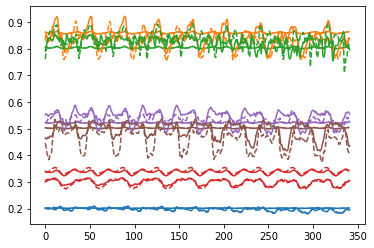

In [11]:
# determine the limb lengths for groudntruth and metrabs data
gt3d_arr = np.array([g['3d'] for k, g in groundtruth.items() if k!=0])
gt_norm_length = np.linalg.norm(gt3d_arr[:, NECK, :] - gt3d_arr[:, PELVIS, :], axis=1)

gt_target_limb_lengths = {}
for l_i, (limb_name, ld) in enumerate(limb_defs.items()):
    lens = []
    for i, lr in enumerate(['left', 'right']):
        a, b = ld[i]
        lengths = np.linalg.norm(gt3d_arr[:, a, :] - gt3d_arr[:, b, :], axis=1) / gt_norm_length
        plt.plot(lengths, label='%s_%s'%(limb_name, lr), color=tab10(l_i), linestyle='--' if i == 0 else '-')
        lens.append(np.mean(lengths))
    gt_target_limb_lengths[limb_name] = np.mean(lens)

    
met3d_arr = np.array([transform_metrabs_to_stadium(f['poses3d'][0].numpy()) for k, f in frame_to_pred.items()])
met_norm_length = np.linalg.norm(met3d_arr[:, NECK, :] - met3d_arr[:, PELVIS, :], axis=1)

met_target_limb_lengths = {}
for l_i, (limb_name, ld) in enumerate(limb_defs.items()):
    lens = []
    for i, lr in enumerate(['left', 'right']):
        a, b = ld[i]
        lengths = np.linalg.norm(met3d_arr[:, a, :] - met3d_arr[:, b, :], axis=1) / met_norm_length
        plt.plot(lengths, label='%s_%s'%(limb_name, lr), color=tab10(l_i), linestyle='--' if i == 0 else '-')
        lens.append(np.mean(lengths))
    met_target_limb_lengths[limb_name] = np.mean(lens)

In [12]:
def get_angle_from_chain(ch):
    a, b, c = ch
    u = a - b
    v = c - b
    u /= np.linalg.norm(u)
    v /= np.linalg.norm(v)
    return np.arccos((u).dot(v)) / np.pi*180

  0%|          | 0/340 [00:00<?, ?it/s]

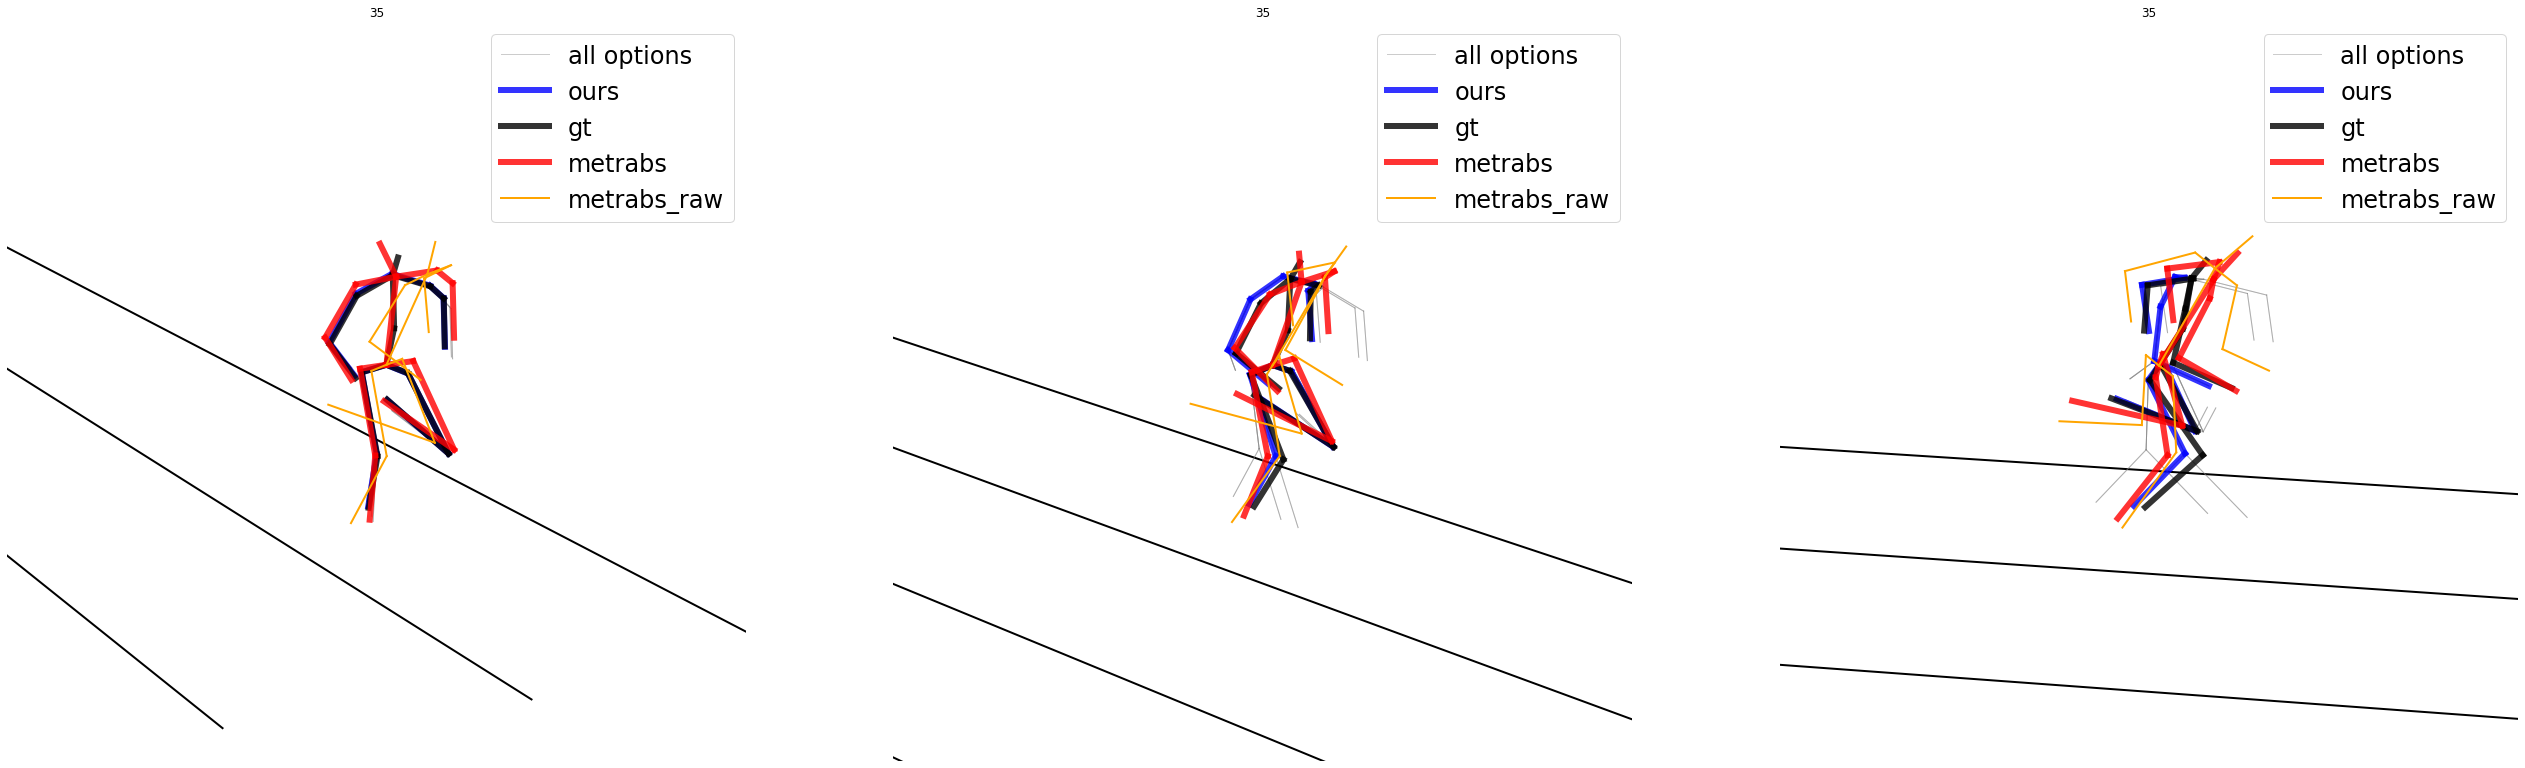

  0%|          | 0/340 [00:01<?, ?it/s]


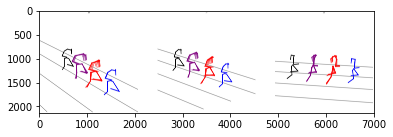

In [53]:
# render positions from first to last frame! --> target positions=equally spaced.
# draw view-target positions for all frames!
import io
from matplotlib import cm

use_gt = True
show_it = True
calc_only = False
imgs_comp = []
compare_data = defaultdict(list)
for frame_i in tqdm(range(1, N)):
    if show_it and not calc_only:
        frame_i = 35
    
    if not calc_only:
        fig = plt.figure(figsize=(45, 25))

    b = groundtruth_to_b(groundtruth[frame_i])

    camrot = groundtruth[frame_i]['camrot']
    gt2d = groundtruth[frame_i]['2d']
    gt3d = groundtruth[frame_i]['3d']

    skel3d = transform_metrabs_to_stadium(frame_to_pred[frame_i]['poses3d'][0].numpy(), np.array(camrot)/2)
    skel3d_norot = transform_metrabs_to_stadium(frame_to_pred[frame_i]['poses3d'][0].numpy())

    metrabs3d = skel3d - skel3d[0]
    metrabs2d = frame_to_pred[frame_i]['poses2d'][0].numpy()[coco_to_h36m]
    metrabs3d += gt3d[0]
    metrabs3d_norot = skel3d_norot - skel3d_norot[0] + gt3d[0]

    # pick the ablation input!!
    if use_gt:
        y_off = gt3d[0][1]
        skel2d_pick = gt2d
        skel3d_pick = gt3d
        limb_length_pick = gt_target_limb_lengths
    else:
        # kinda fair to chose the gt offset, since we can get there using steps!
        y_off = gt3d[0][1]
        skel2d_pick = metrabs2d
        skel3d_pick = metrabs3d
        limb_length_pick = met_target_limb_lengths
    
    skel2d_pick = skel2d_pick.copy()
    skel2d_pick[:, 1] = 720 - skel2d_pick[:, 1]
        
    skel3d_const, sk3d, skel_options, torso_target, = skel_placement_for_frame(b, skel2d_pick, skel3d_pick,
                                                                               y_off, limb_length_pick)
           
    new_skel = np.zeros((17, 3))
    for name, opt in skel_options.items():
        idx = limb_chains[name]
                
        sk_comp = sk3d[idx,:] - sk3d[0]
    
        opt2 = np.array(opt) - skel3d_const[0]
        diff_sk = np.array(opt2) - sk_comp[np.newaxis, ...]
        diff = np.mean(np.linalg.norm(diff_sk, axis=2), 1)
        
        if 'leg' in name and False:
            min_idx = np.argmin(np.std(np.array(opt)[:, 1:, 1], axis=1))
        else:
            min_idx = np.argmin(diff)
            
        new_skel[idx, :] = opt[min_idx]
        
    skel3d_const = new_skel

    # compute the reprojection error!!
    metrabs_proj = project_lines(b, metrabs3d)
    metrabs_proj[:, 1] = 720 - metrabs_proj[:, 1]
    
    skel3d_const_proj = project_lines(b, skel3d_const)
    skel3d_const_proj[:, 1] = 720 - skel3d_const_proj[:, 1]
    
    metrabs_err = np.mean(np.linalg.norm(gt2d - metrabs_proj, axis=1)[good_idc])
    skel3d_err = np.mean(np.linalg.norm(gt2d - skel3d_const_proj, axis=1)[good_idc])

    pelv_const = skel3d_const[0].copy()
    if not use_gt:
        skel3d_const -= pelv_const
        skel3d_const += gt3d[0]
    
    compare_data['gt'].append(gt3d)
    compare_data['metrabs'].append(metrabs3d)
    compare_data['metrabs_norot'].append(metrabs3d_norot)
    compare_data['lift3d'].append(skel3d_const)
    
    if not calc_only:
        for fig_i, view_ang in enumerate([[10, 0], [15, 20], [20, 60]]):
            ax3d = plt.subplot(1, 3, fig_i+1, projection='3d')
            # == plotting ==

            i = 0
            for limb, opts in skel_options.items():
                for opt_i, opt in enumerate(opts):
                    if not use_gt:
                        opt = opt - pelv_const + gt3d[0]
                    for o in range(len(opt)-1):
                        ax3d.plot3D(*np.vstack((opt[o], opt[o+1])).T, color='gray', linewidth=1, alpha=.4, label='all options' if i==0 else None)
                        i+=1

            for i, l in enumerate(pos_to_coco_lines(skel3d_const)):
                if i in [3, 4, 5]:
                    continue
                ax3d.plot3D(*l.T, color='blue', linewidth=6, alpha=.8, label='ours' if i==0 else None)

            for i, l in enumerate(pos_to_coco_lines(gt3d)):
                ax3d.plot3D(*l.T, color='black', linewidth=6, alpha=.8, label='gt' if i==0 else None)

            for i, l in enumerate(pos_to_coco_lines(metrabs3d)):
                ax3d.plot3D(*l.T, color='red', linewidth=6, alpha=.8, label='metrabs' if i==0 else None)

            for i, l in enumerate(pos_to_coco_lines(metrabs3d_norot)):
                ax3d.plot3D(*l.T, color='orange', linewidth=2, label='metrabs_raw' if i==0 else None)

            ax3d.set_title(frame_i)

            x,y,z = gt3d[0]
            ax3d.set_xlim(x-.75, x+.75)
            ax3d.set_ylim(y-.75, y+.75)
            ax3d.set_zlim(0, 1.5)

#             ax3d.view_init(20, -20 - fig_i*20)
            ax3d.view_init(view_ang[0], -20-view_ang[1])
            ax3d.axis('off')
            ax3d.legend(fontsize=24)
            draw_short_lanes(ax3d, scale=.75, nlanes=4, len_straight_short=x+2)

        if show_it:
            plt.show()
            break

        img_buf = io.BytesIO()
        fig.savefig(img_buf, format='jpg', dpi=200, bbox_inches='tight')

        im = np.array(Image.open(img_buf))[..., :3]
        imgs_comp.append(im)
        plt.clf()
        plt.close()
        
plt.imshow(im)

freq 38.0
ms / rep 633.3333333333333
steps / min 189.47368421052633


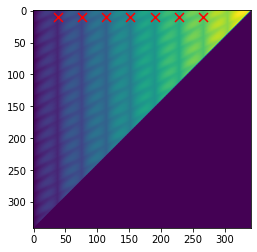

In [49]:
# determine the frequency of the running form via self-similarity

positions = gt3d_arr

N = len(positions)
# positions = letes3d
corr = np.zeros((N, N))
for i in range(N):
    for j in range(i, N):
        p0 = positions[i].copy()
        p1 = positions[j].copy()
        p0 -= p0[0]
        p1 -= p1[0]
        d = np.mean(np.sqrt(np.sum((p0 - p1)**2, 1)))
        corr[i, j-i] = d
plt.imshow(corr)

corr_sum = np.sum(corr, 0)

mins = []
wd = 10
for i in range(wd//2, N-wd//2):
    if np.all(corr_sum[i] < corr_sum[i-wd//2:i]) and np.all(corr_sum[i] < corr_sum[i+1:i+wd//2]):
        plt.scatter(i, 10, color='red', marker='x', s=80)
        mins.append(i)

mins = np.array(mins)
# plt.plot(corr_sum*5, color='red', linewidth=2)
fps = 60
freq = np.mean(mins[1:] - mins[:-1])
s_per_step = freq / fps
print('freq', freq)
print('ms / rep', s_per_step*1000)
print('steps / min', 60 / s_per_step * 2)

In [50]:
# compile the images into self-similarity maps for each parts of running step

show_it = False

r_z = R.from_euler('z', 50, degrees=True).as_matrix()

imgs_self = []
for k in tqdm(range(int(freq))):
    fig = plt.figure(figsize=(45, 15))
    
    colors = {'gt': 'black', 'metrabs_norot': 'purple', 'metrabs': 'red', 'lift3d': 'blue'}
#     colors = {'gt': 'black', 'metrabs': 'red', 'lift3d': 'blue'}
    
    for view_i, view_ang in enumerate([[10, 0], [15, 20], [20, 60]]):       
        ax = plt.subplot(1, 3, view_i+1, projection='3d')
        for i, key in enumerate(colors.keys()):
            shift = [i-.5, 0, 0]
            data = compare_data[key]
            for m in mins:
                if m+k < len(data):
                    gt = data[m+k].copy()
                    if key == 'metrabs_norot':
                        gt = gt.dot(r_z)

                    gt -= gt[0]
                    for j, l in enumerate(pos_to_coco_lines(gt)):
                        if j in [3, 4, 5]:
                            continue
                        ax.plot3D(*(l + shift).T, color=colors[key], linewidth=6, alpha=.5)
        
        ax.set_title(k)
        if view_i == 0:
            ax.set_xlim(-.5, 1)
        elif view_i == 2:
            ax.set_xlim(-.5, 2.5)
        else:
            ax.set_xlim(-.5, 2)
        ax.set_ylim(-.5, 1.5)
        ax.set_zlim(-1, 1)
        
        draw_short_lanes(ax, shift=.25, scale=.75, nlanes=4, len_straight_short=5)
        ax.axis('off')
                
        ax.view_init(view_ang[0], -20-view_ang[1])

    img_buf = io.BytesIO()
    fig.savefig(img_buf, format='jpg', dpi=200, bbox_inches='tight')
    im = np.array(Image.open(img_buf))[..., :3]
    imgs_self.append(im)
    plt.clf()
    plt.close()

    if show_it:
        plt.figure(figsize=(45, 15))
        plt.imshow(im)
        plt.axis('off')
        break

100%|██████████| 38/38 [01:29<00:00,  2.35s/it]


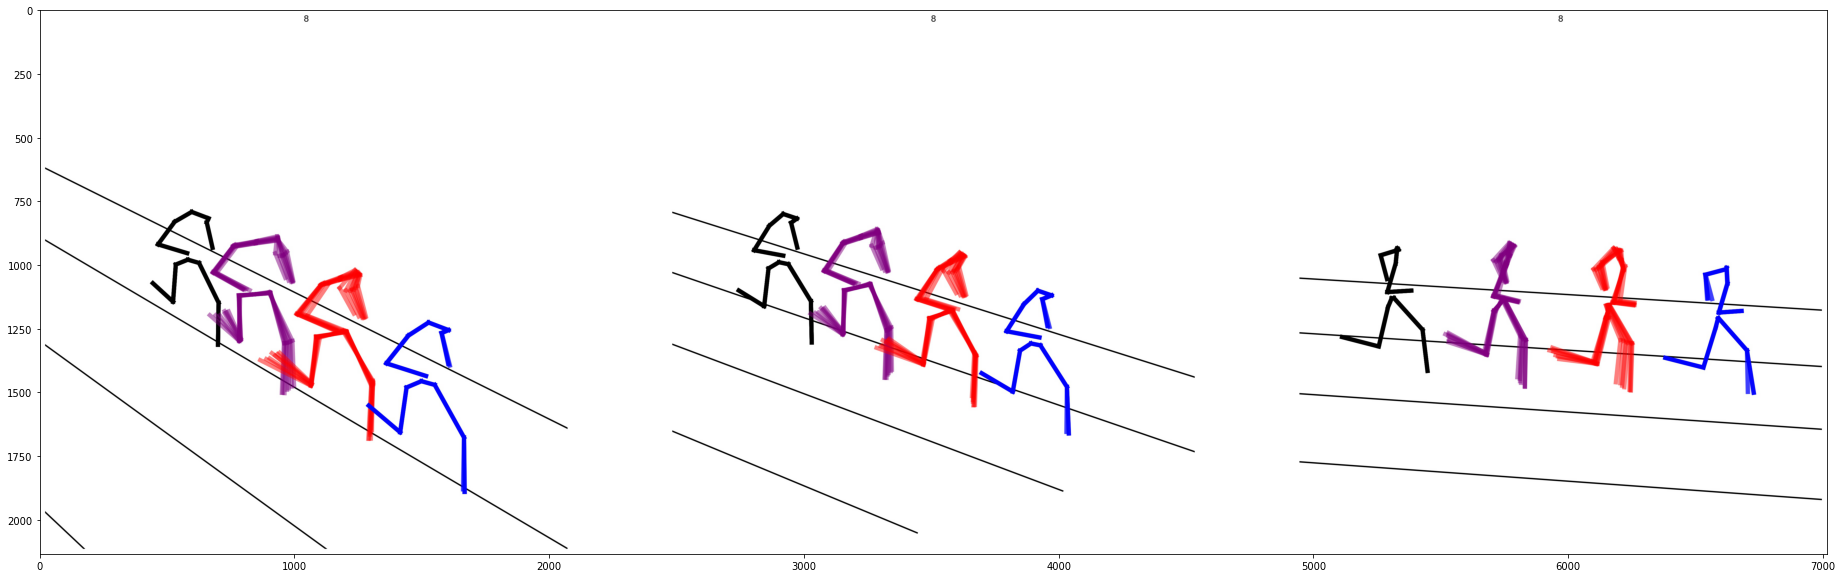

In [51]:
# plt.figure(figsize=(45,10))
# plt.imshow(imgs_comp[8])
plt.figure(figsize=(45,10))
plt.imshow(imgs_self[8])

# img_pil_comp = Image.fromarray(imgs_comp[5])
# img_pil_comp.save('plots/img_comp.png')

# img_pil_self = Image.fromarray(imgs_self[8])
# img_pil_self.save('plots/img_self.png')

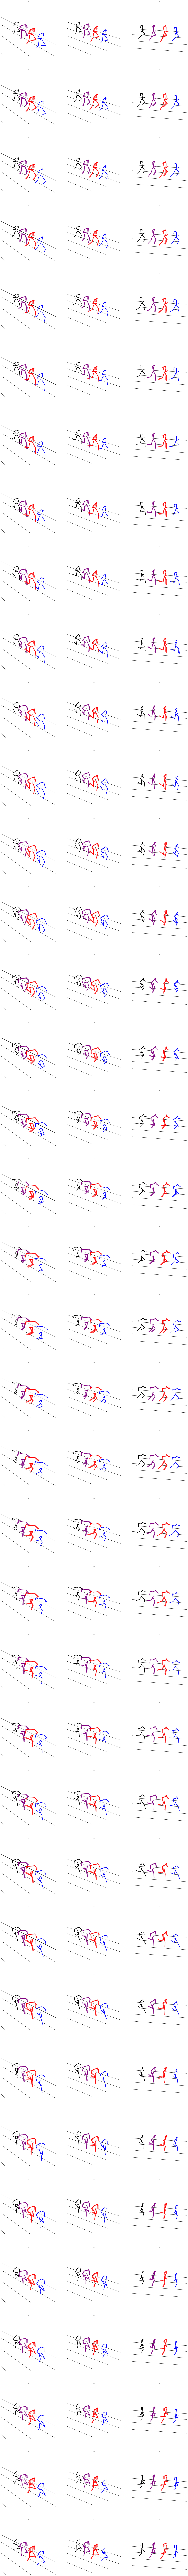

In [52]:
M = len(imgs_self)
fig, axs = plt.subplots(nrows=M, figsize=(45, M*10))
for j, img in enumerate(imgs_self):
    axs[j].imshow(img)
    axs[j].axis('off')